### Demo of Registering Distorted LIDAR Scans to HD Map Provided in Newer College Dataset

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-06-18 15:05:28.832923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 15:05:28.933674: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-18 15:05:29.318221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-18 15:05:29.318272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-18 15:05:29.998651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 15:05:29.999906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 15:05:30.000197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 15:05:30.000416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#Load HD Map from .ply File
import trimesh

# pl = '/home/derm/Downloads/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply' #provided in Google Drive 03
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# print(type(HD_map))

# Draw HD Map

In [3]:
#Test drawing downsampled version of HD Map (laptop alert)
show_nth = 10 #10
submap = HD_map[::show_nth]
# submap[:,2] += min(submap[:,2])
print(np.shape(submap))

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

## rainbow by z height
# # zheight = 50*(np.sin(0.0625*submap[:,2])+1)#was this
# zheight = 100*(np.sin(0.25*submap[:,2])+1) #test
# print(zheight[::100], min(zheight), max(zheight))
# # cname = np.array([zheight, 100*(np.sin(0.5*zheight+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# cname = np.array([zheight, zheight, zheight]).T.tolist()
# # cname = np.array([64*np.ones(len(zheight)), 256 - zheight/2, 256 - zheight]).T.tolist()
# disp.append(Points(submap, c = cname, r = 2, alpha = 0.1))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Register scan using rigid ICET

In [ ]:
idx = 400
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"

pc1 = np.load(fn1)

#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(gt[idx, 2:])

offset = 0#for debug 
rot = R.from_quat(gt[idx+offset,5:]).as_euler('xyz')
# rot_m = R.from_quat(gt[idx+offset,5:]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
rot_m = R.from_euler('xyz', [0, 0, rot[2]]).as_matrix()
# rot_m = R.from_euler('xyz', [rot[0], rot[1], -rot[2] - np.pi/8 ]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# print(rot_m)

initial_guess = tf.cast(tf.constant([gt[idx+offset,2], gt[idx+offset,3], gt[idx+offset,4], rot[0], rot[1], rot[2] ]), tf.float32)
# pc1 = pc1 @ rot_m
# rotcorr = R.from_euler('xyz', [0,0,np.pi/8]).as_matrix() #need to correct 45 degree offset??
# pc1 = pc1 @ rotcorr
# pc1 += initial_guess[:3]

# Get Ground Truth Poses with code from KitWare pyLiDAR-SLAM library

In [ ]:
#load ground truth .csv file
# [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #debugging possible sign errors
poses = np.einsum("nij,jk->nik", poses, T_CL)

initial_pose = np.linalg.inv(poses[0]) 

poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

fwd_vel = np.sqrt(np.diff(poses[:,0,3])**2 + np.diff(poses[:,1,3])**2)
ax.plot(fwd_vel)

## Regsiter Raw Clouds i, j, and HD Map centered on origin of i 

In [ ]:
# idx = 2700 #2650 #2000 - 3000 is the running and swinging loop
# skip = 5 #how many lidar frames between clouds
# # (need to deal with how there are more LIDAR frames than ground truth poses)
# offset = 11 #10 #11  #works best for 05 dataset
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

idx = 990 #1080 #950 #fast motion
# idx = 116 #slow distortion, very accurate solution
skip = 1 #how many lidar frames between clouds
offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

#Rotate scans to align beginning of each scan with +X axis ----------
#IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
#           this is becuase overall trajectory begins at 05 (at least I think that's why)
#Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
#--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#COLOR SCAN1 POINTS BY ORDER IN CLOUD
color = 255*np.linspace(0,1,len(scan1_lidarframe))
cname = np.array([255-color//2, color, 255-color]).T.tolist()
disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))

# # DRAW SCANS 1, 2
# disp.append(Points(scan1_lidarframe, c = '#a65852', r = 3)) #red
# disp.append(Points(scan2_lidarframe, c = '#2c7c94', r = 3)) #blue

disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314
plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


## Run 12-State ICET

In [ ]:
from linear_corrector import LC
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

# #scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 100, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# scan to scan
dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 50, niter = 10, 
        draw = True, mnp = 25, RM = False, solver = '12_state', 
        max_buffer = 2.5, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

## Calculate chamfer distance before and after rectification on single frame

#### From the GitHub README:
Here, dist is the Chamfer distance between source_cloud and target_cloud. Note that Chamfer distance is not bidirectional (and, in stricter parlance, it is not a distance metric).
https://github.com/krrish94/chamferdist/tree/master

In [ ]:
import torch
from chamferdist import ChamferDistance

chamferDist = ChamferDistance()

source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
source_cloud_trans = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #transformed scan

#need to downsample to keep runtime down
target_cloud = torch.from_numpy(submap_lidarframe[::10,:3].astype(np.float32))[None,:,:] #faster but slightly less accurate?
# target_cloud = torch.from_numpy(submap_lidarframe.astype(np.float32))[None,:,:] # tAkEs SooOoOO LoNg tO run...


dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
dist_forward_trans = chamferDist(source_cloud_trans, target_cloud)
print("Chamfer Distance after transform: \n:", dist_forward_trans.detach().cpu().item())

print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
print("\n Normalized transformed CD: \n", dist_forward_trans/len(dc.cloud2_tensor))

# Load LOAM Results

(1366, 6)


<IPython.core.display.Javascript object>


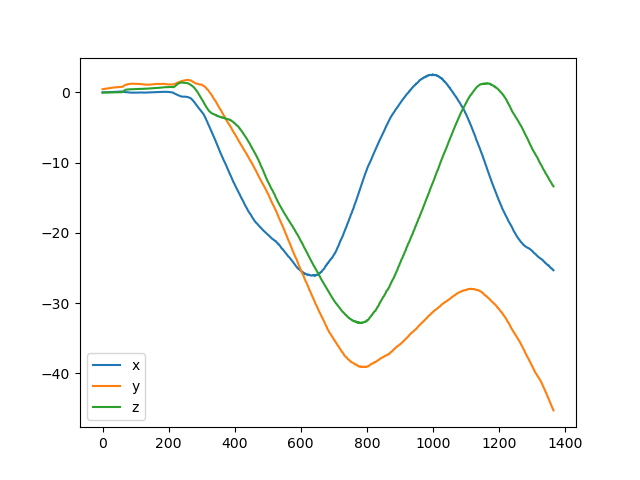

In [5]:
# fn = "results/LOAM/05_test1.npy"
fn = "results/LOAM/05_test2.npy"
LOAM_traj = np.load(fn)
# LOAM_traj = np.diff(np.load(fn))
print(np.shape(LOAM_traj))

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# disp=[]
# # draw in red
# disp.append(Points(LOAM_traj[:,:3], c = 'black', r = 3, alpha = 0.5))  

# plt.show(disp, "HD Map")
# ViewInteractiveWidget(plt.window)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(LOAM_traj[:,0], label = "x")
ax.plot(LOAM_traj[:,1], label = "y")
ax.plot(LOAM_traj[:,2], label = "z")
ax.legend(loc="best")


# Calculate Chamfer Distance for 100 frame sequence: $\textit{Dynamic Spinning}$ Trajectory

Returns results for:

"ground truth" --> CD when using ground truth poses provided by creators of the dataset

"Rigid ICET" --> ICET/ NDT registration of raw point clouds with no motion compensation

VICET --> Our proposed method

In [ ]:
runlen = 100 #100
start_idx = 950 #beginning of 10s of chaotic motion

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

    #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
    #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
    submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 2.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
        dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 100, 
                draw = False, mnp = 25, RM = False, solver = '12_state', 
                max_buffer = max_buffer, A0 = A0)
    except:
        pass
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 15, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
    source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
    source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #need to downsample to keep runtime down
    target_cloud = torch.from_numpy(submap_lidarframe[::10,:3].astype(np.float32))[None,:,:] 

    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)
    

In [ ]:
# np.savetxt("results/raw_CD_06_950_v2.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_06_950_v2.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_06_950_v2.txt", VICET_CD_hist)

# rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_06_950.txt")
# VICET_CD_hist = np.loadtxt("results/VICET_CD_06_950.txt")

# #throw out obvious outliers
# bad_idx = np.where(VICET_CD_hist > raw_CD_hist)
# VICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]
# bad_idx = np.where(rigid_ICET_CD_hist > raw_CD_hist)
# rigid_ICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]

VICET_CD_hist[VICET_CD_hist == 0.1 ] = 0.3

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))

# Calculate Chamfer Distance over 1000 frames in $\textit{Quad With Dynamics}$ 

In [ ]:
runlen = 10 #100
start_idx = 2700 #2000 #one full loop running around the quad

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

err_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

#     #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
#     #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
#     #           this is becuase overall trajectory begins at 05 (at least I think that's why)
#     #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
#     scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
#     submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
        dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 20, 
                draw = False, mnp = 25, RM = False, solver = '12_state', 
                max_buffer = max_buffer, A0 = A0)
    except:
        err_hist[idx] = 1
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
    source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
    source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #need to downsample to keep runtime down
    every_nth = 10
    target_cloud = torch.from_numpy(submap_lidarframe[::10,:3].astype(np.float32))[None,:,:] 
    
    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)
    

In [ ]:
# np.savetxt("results/raw_CD_05.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05.txt", VICET_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

print(err_hist)

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))

In [ ]:
#debug is cloud wrapping around >>360deg???
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

y = dc.yaw_angs
yaw_angs_scaled = (y + 2*np.pi)%(2*np.pi)
# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
ax.plot(yaw_angs_scaled, label="new")

#get indices len(yaw_angs_scaled)//8 where yaw_angs_scaled is less than pi  
problem_idx = np.argwhere(yaw_angs_scaled[:len(yaw_angs_scaled)//8] < np.pi)
all_idx = np.linspace(0,len(yaw_angs_scaled)-1, len(yaw_angs_scaled))
good_idx = np.setdiff1d(all_idx, problem_idx).astype(np.int32)
ax.plot(yaw_angs_scaled[problem_idx])
ax.plot(good_idx, yaw_angs_scaled[good_idx])

# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
# ax.plot(ordered_yaw_angs, label = "raw (causing bug??)")
# ordered_yaw_angs = (dc.yaw_angs[np.argsort(dc.yaw_angs)] + np.pi) % (2*np.pi)
ax.set_title("yaw angles per beam, newer college dataset")
ax.legend(loc="best")

In [ ]:
#debug: try applying arbitrary motion profile scan to try and replicate discontinuity bug 
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


m_hat = np.array([10., 0., 0., 0., 0., 0.])

scan1_distorted = dc.apply_motion_profile(scan1_lidarframe, m_hat)


disp.append(Points(scan1_lidarframe, c = "red", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(scan1_distorted, c = "blue", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG: shuffling points in cloud 2 at the beginning produces bug, however, need to randomize 
#       which points are selected when fitting guassian

# print(dc.inside2.bounding_shape())
test = dc.fit_gaussian(dc.cloud2_tensor, dc.inside2, tf.cast(dc.npts2, tf.float32))
# print(test)
# print(tf.shape(dc.cloud2_tensor))
# print(dc.inside2[100])

#GOAL: shuffle ragged tensor <inside2>
digits = tf.ragged.constant([[1,2,3],[],[3,4],[4,5,6,7]])
print(digits)
a = tf.random.shuffle(tf.range(digits.shape[0]))
b = tf.reshape(a, (digits.shape[0], 1))
shuffledDigits = tf.gather_nd(digits, b)
print(shuffledDigits)

print(dc.inside2.bounding_shape())

## Run Rigid (6-State) ICET

In [ ]:
it = ICET(cloud1 = scan1_lidarframe, cloud2 = submap_lidarframe, fid = 50, niter = 25, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
print(it.cloud2_tensor.numpy())

In [ ]:
test = dc.cloud1_tensor_spherical
print(test)

# test2 = tf.gather(tf.)

smaller = tf.where(test[:,1] < 0.5)
print(smaller)
bigger = tf.where(test[:,1] > 0.4)
test2 = tf.sets.intersection(tf.transpose(smaller),tf.transpose(bigger))
print(test2.values)

print(tf.gather(test, test2.values))

In [ ]:
#transform LIDAR scan to align with HD Map -- not what we want
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

# #matt's attempt:
# rot_m = R.from_quat(gt[idx,5:]).as_matrix()
# newscan_mapframe = (pc1 @ rot_m) + gt[idx,2:5]
# disp.append(Points(newscan_mapframe, c = 'blue',r = 2))

#kitware code
newscan_mapframe = (poses[idx] @ np.append(pc1, np.zeros([len(pc1),1]), axis=1).T).T
print(newscan_mapframe)
disp.append(Points(newscan_mapframe[:,:3], c = 'blue',r = 2))

#draw trajectory of platform according to <gt>
disp.append(Points(gt[2200:3000,2:5], r=3))#, alpha = 0.2))
disp.append(Points(gt[idx+offset,2:5][None,:], r=10, c = 'red'))

#draw arrows showing heading
for i in range(50):
    rot_m = R.from_quat(gt[i*20,5:]).as_matrix()
    arrow_end = gt[i*20,2:5] + rot_m @ np.array([2.,0.,0.])
    disp.append(Arrow(gt[i*20,2:5], arrow_end, c='red'))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG
from matplotlib import pyplot as plt

euls = np.zeros([len(gt), 3])

for i in range(len(gt)):
    euls[i, :] = R.from_quat(gt[i,5:]).as_euler('xyz')

fig, ax = plt.subplots()
ax.plot(euls[:,2])

# ax.plot(gt[:,2:4])
# ax.plot(gt[:,0])

In [ ]:
# #transform HD Map to align with lidar frame
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# disp=[]

# # rot_m = R.from_quat(gt[idx,5:]).as_matrix() #nope

# rot = R.from_quat(gt[:,5:]).as_euler('xyz')
# rot -= rot[0]
# rot[:,2] = -rot[:,2]
# # print(rot)
# rot_m = R.from_euler('xyz', rot[idx]).as_matrix()

# map_trans = (submap - gt[idx, 2:5]) @ rot_m
# disp.append(Points(pc1, c = 'blue', r = 3))
# # disp.append(Points(pc1[:(len(pc1)//2)], c = 'blue', r = 3))
# # disp.append(Points(pc1[(len(pc1)//2):], c = 'blue', r = 3, alpha = 0.2))

# #draw axis for world frame
# disp.append(Arrow([0,0,0], [2,0,0], c = 'red'))
# disp.append(Arrow([0,0,0], [0,2,0], c = 'green'))
# disp.append(Arrow([0,0,0], [0,0,2], c = 'blue'))
# #draw axis for world frame transformed by rot_m
# disp.append(Arrow([0,0,0], [2,0,0] @ rot_m, c = 'red', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,2,0] @ rot_m, c = 'green', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,0,2] @ rot_m, c = 'blue', alpha = 0.2))


# disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))

# disp.append(Points(map_trans, c = 'red', r = 2, alpha = 0.2))
# plt.show(disp, "HD Map")
# ViewInteractiveWidget(plt.window)

In [ ]:
# newscan_mapframe = np.append(pc1, np.zeros([len(pc1),1]), axis=1)
# newscan_mapframe = poses[1] @ newscan_mapframe.T
# print(newscan_mapframe.T)

In [ ]:
# print(rot)
# rot_m @ np.array([0.,0.,0.])

In [ ]:
# map_trans = (submap - gt[idx, 2:5]) @ rot_m

# it = ICET(cloud1 = pc1, cloud2 = map_trans, fid = 50, niter = 5, 
#            draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
# print("\n predicted standard deviations of error: \n", it.pred_stds)
# ViewInteractiveWidget(it.plt.window)